In [46]:
from quadriga import QuadrigaClient
import crycompare
import pandas as pd
from pandas.io.json import json_normalize
import datetime
import time
import math
from keras.models import Model, load_model
from keras.layers.core import Dense, Dropout, Activation
from keras.layers import Input
from keras.regularizers import l2
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from keras.layers.recurrent import LSTM
import numpy as np
import pandas as pd
import sklearn.preprocessing as prep

import matplotlib.pyplot as plt2


In [47]:
client = QuadrigaClient(
    api_key='nBJnmjCKLB',
    api_secret='31e20c574080e3a646e859e8faf288d9',
    client_id='2039791',
    default_book='eth_btc'
)


In [3]:
hist = crycompare.History()

res = hist.histoHour('ETH','BTC',e='QuadrigaCX', limit=2000)
data = []
data.extend(res['Data'])
while True:
    lasttime = res['TimeFrom']
    res = hist.histoHour('ETH','BTC',e='QuadrigaCX', limit=2000, toTs=res['TimeFrom'])
    if len(res['Data']):
        data = res['Data'][:-1] + data
    else:
        break
    
empty = []
for i,x in enumerate(data):
    s = 0
    for y in x:
        if not y=='time': s += x[y]
    if s==0:
        empty.append(i)
    else:
        x['time'] = str(datetime.datetime.fromtimestamp(x['time']))

for x in reversed(empty):
    data.pop(x)
    
df = json_normalize(data)

col_list = df.columns.tolist()
col_list.remove('time')
df = df[col_list]

In [256]:
def standard_scaler(X_train, X_test):
    train_samples, train_nx, train_ny = X_train.shape
    test_samples, test_nx, test_ny = X_test.shape
    
    X_train = X_train.reshape((train_samples, train_nx * train_ny))
    X_test = X_test.reshape((test_samples, test_nx * test_ny))
        
    preprocessor = prep.StandardScaler().fit(X_train)
    X_train = preprocessor.transform(X_train)
    X_test = preprocessor.transform(X_test)
    
    X_train = X_train.reshape((train_samples, train_nx, train_ny))
    X_test = X_test.reshape((test_samples, test_nx, test_ny))
    
    return X_train, X_test, preprocessor

def inverse_scaler(valx, valy, preprocessor):
    if len(valy.shape)==2:
        valy = np.expand_dims(valy,axis=1)
    val = np.append(valx, valy, axis=1)
    val_samples, val_nx, val_ny = val.shape
    val = val.reshape((val_samples, val_nx*val_ny))
    
    val = preprocessor.inverse_transform(val)
    val = val.reshape((val_samples, val_nx, val_ny))
    valx = val[:,:-1]
    valy = val[:,-1]
    
    return valx, valy

def preprocess_data(df, seq_len, res_len):
    stock = pd.rolling_mean(df, 24).dropna().reset_index(drop=True)
#     stock = df.rolling(24).sum().dropna().reset_index(drop=True)
    amount_of_features = len(stock.columns)
    data = stock.as_matrix()
    
    sequence_length = seq_len + res_len
    result = []
    for index in range(len(data) - sequence_length):
        result.append(data[index : index + sequence_length])
        
    result = np.array(result)
    row = round(0.9 * result.shape[0])
    train = result[: int(row), :]
    
    train, result, preprocessor = standard_scaler(train, result)
    
    X_train = train[:,:-res_len]
    y_train = train[:,-res_len:]
    X_test = result[int(row):,:-res_len]
    y_test = result[int(row):,-res_len:]

    X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], amount_of_features))
    X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], amount_of_features)) 
#     y_train = np.reshape(y_train, (y_train.shape[0], y_train.shape[1]*y_train.shape[2]))
#     y_test = np.reshape(y_test, (y_test.shape[0], y_test.shape[1]*y_test.shape[2]))

    return [X_train, y_train, X_test, y_test], preprocessor

def build_model(layers):
#     print layers[0]
    l = Input(layers[0])
    x = LSTM(layers[1],
        return_sequences=True, kernel_initializer='he_normal', kernel_regularizer=l2(0.0001))(l)
    x = Dropout(0.4)(x)
    
    x = LSTM(layers[2],
        return_sequences=False, kernel_initializer='he_normal', kernel_regularizer=l2(0.0001))(x)
    x = Dropout(0.3)(x)
    
    size = layers[3]
    x = Dense(output_dim=size[0]*size[1], kernel_initializer='he_normal', kernel_regularizer=l2(0.0001))(x)
    x = Activation("linear")(x)
    
    model = Model(l,x) 
    start = time.time()
    model.compile(loss="mse", optimizer="adam", metrics=['accuracy'])
    print("Compilation Time : ", time.time() - start)
    return model
    

In [257]:
window = 24
(X_train, y_train, X_test, y_test), preprocessor = preprocess_data(df, window, 1)
_,xy,yy = y_test.shape
print("X_train", X_train.shape)
print("y_train", y_train.shape)
print("X_test", X_test.shape)
print("y_test", y_test.shape)

('X_train', (10882, 24, 6))
('y_train', (10882, 1, 6))
('X_test', (1209, 24, 6))
('y_test', (1209, 1, 6))


/home/tommy/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:32: FutureWarning: pd.rolling_mean is deprecated for DataFrame and will be removed in a future version, replace with 
	DataFrame.rolling(window=24,center=False).mean()


In [190]:
model = load_model('weights-stock.best.hdf5')

In [258]:
model = build_model([X_train[0].shape, window, 100, y_train[0].shape])
# model = build_model([X_train[0].shape, window, window*2, y_train[0].shape])

# early = EarlyStopping(monitor='val_acc', patience=15, verbose=1, mode='auto')
filepath = "weights-stock-test2.best.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')
lr_reducer = ReduceLROnPlateau(factor=np.sqrt(0.1), monitor='val_loss', cooldown=0, patience=20, min_lr=0.5e-6, verbose=1)

model.fit(
    X_train,
    np.reshape(y_train, (y_train.shape[0], y_train.shape[1]*y_train.shape[2])),
    batch_size=128,
    epochs=200,
    validation_split=0.1,
    verbose=1,
    callbacks=[checkpoint, lr_reducer])

/home/tommy/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:72: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(units=6, kernel_regularizer=<keras.reg..., kernel_initializer="he_normal")`


('Compilation Time : ', 0.019731998443603516)
Train on 9793 samples, validate on 1089 samples
Epoch 1/200
9793/9793 [==============================] - 7s 693us/step - loss: 0.4461 - acc: 0.3958 - val_loss: 0.3902 - val_acc: 0.4096
Epoch 2/200
9793/9793 [==============================] - 3s 338us/step - loss: 0.1949 - acc: 0.4958 - val_loss: 0.2766 - val_acc: 0.4389
Epoch 3/200
9793/9793 [==============================] - 3s 337us/step - loss: 0.1459 - acc: 0.5115 - val_loss: 0.2116 - val_acc: 0.5500
Epoch 4/200
9793/9793 [==============================] - 4s 362us/step - loss: 0.1292 - acc: 0.5339 - val_loss: 0.2307 - val_acc: 0.5032
Epoch 5/200
9793/9793 [==============================] - 4s 374us/step - loss: 0.1061 - acc: 0.5440 - val_loss: 0.2210 - val_acc: 0.4417
Epoch 6/200
9793/9793 [==============================] - 3s 348us/step - loss: 0.0986 - acc: 0.5490 - val_loss: 0.2336 - val_acc: 0.6061
Epoch 7/200
9793/9793 [==============================] - 3s 353us/step - loss: 0.087

9793/9793 [==============================] - 4s 389us/step - loss: 0.0341 - acc: 0.6290 - val_loss: 0.1618 - val_acc: 0.8476
Epoch 31/200
9793/9793 [==============================] - 4s 414us/step - loss: 0.0316 - acc: 0.6260 - val_loss: 0.1543 - val_acc: 0.8503
Epoch 32/200
9793/9793 [==============================] - 4s 358us/step - loss: 0.0320 - acc: 0.6283 - val_loss: 0.1767 - val_acc: 0.8466
Epoch 33/200
9793/9793 [==============================] - 4s 402us/step - loss: 0.0324 - acc: 0.6305 - val_loss: 0.1484 - val_acc: 0.8274
Epoch 34/200
9793/9793 [==============================] - 4s 384us/step - loss: 0.0317 - acc: 0.6220 - val_loss: 0.1507 - val_acc: 0.8522
Epoch 35/200
9793/9793 [==============================] - 4s 405us/step - loss: 0.0300 - acc: 0.6245 - val_loss: 0.1569 - val_acc: 0.8512
Epoch 36/200
9793/9793 [==============================] - 3s 336us/step - loss: 0.0340 - acc: 0.6296 - val_loss: 0.1692 - val_acc: 0.8439
Epoch 37/200
9793/9793 [=======================

Epoch 61/200
9793/9793 [==============================] - 3s 311us/step - loss: 0.0225 - acc: 0.6798 - val_loss: 0.1535 - val_acc: 0.8457
Epoch 62/200
9793/9793 [==============================] - 3s 340us/step - loss: 0.0230 - acc: 0.6753 - val_loss: 0.1258 - val_acc: 0.8632
Epoch 63/200
9793/9793 [==============================] - 4s 382us/step - loss: 0.0236 - acc: 0.6867 - val_loss: 0.1418 - val_acc: 0.8577
Epoch 64/200
9793/9793 [==============================] - 4s 362us/step - loss: 0.0217 - acc: 0.6785 - val_loss: 0.1182 - val_acc: 0.8503
Epoch 65/200
9793/9793 [==============================] - 3s 309us/step - loss: 0.0215 - acc: 0.6798 - val_loss: 0.1315 - val_acc: 0.8448
Epoch 66/200
9793/9793 [==============================] - 3s 315us/step - loss: 0.0220 - acc: 0.6928 - val_loss: 0.1210 - val_acc: 0.8540
Epoch 67/200
9793/9793 [==============================] - 3s 319us/step - loss: 0.0234 - acc: 0.7068 - val_loss: 0.1279 - val_acc: 0.8494
Epoch 68/200
9793/9793 [==========

Epoch 93/200
9793/9793 [==============================] - 3s 318us/step - loss: 0.0184 - acc: 0.7251 - val_loss: 0.1271 - val_acc: 0.8567
Epoch 94/200
9600/9793 [============================>.] - ETA: 0s - loss: 0.0186 - acc: 0.7351Epoch 00094: val_acc did not improve

Epoch 00094: reducing learning rate to 0.000316227781037.
9793/9793 [==============================] - 4s 427us/step - loss: 0.0186 - acc: 0.7356 - val_loss: 0.1329 - val_acc: 0.8531
Epoch 95/200
9793/9793 [==============================] - 3s 341us/step - loss: 0.0182 - acc: 0.7438 - val_loss: 0.1067 - val_acc: 0.8595
Epoch 96/200
9793/9793 [==============================] - 3s 303us/step - loss: 0.0171 - acc: 0.7480 - val_loss: 0.1113 - val_acc: 0.8613
Epoch 97/200
9793/9793 [==============================] - 4s 377us/step - loss: 0.0176 - acc: 0.7474 - val_loss: 0.1117 - val_acc: 0.8577
Epoch 98/200
9793/9793 [==============================] - 3s 340us/step - loss: 0.0175 - acc: 0.7445 - val_loss: 0.1110 - val_acc: 0.

Epoch 125/200
9793/9793 [==============================] - 3s 294us/step - loss: 0.0166 - acc: 0.7495 - val_loss: 0.1345 - val_acc: 0.8586
Epoch 126/200
9793/9793 [==============================] - 3s 299us/step - loss: 0.0163 - acc: 0.7468 - val_loss: 0.1329 - val_acc: 0.8595
Epoch 127/200
9793/9793 [==============================] - 3s 301us/step - loss: 0.0164 - acc: 0.7482 - val_loss: 0.1251 - val_acc: 0.8586
Epoch 128/200
9793/9793 [==============================] - 3s 292us/step - loss: 0.0172 - acc: 0.7483 - val_loss: 0.1251 - val_acc: 0.8595
Epoch 129/200
9793/9793 [==============================] - 3s 307us/step - loss: 0.0164 - acc: 0.7489 - val_loss: 0.1269 - val_acc: 0.8586
Epoch 130/200
9793/9793 [==============================] - 3s 294us/step - loss: 0.0163 - acc: 0.7529 - val_loss: 0.1286 - val_acc: 0.8586
Epoch 131/200
9793/9793 [==============================] - 3s 290us/step - loss: 0.0160 - acc: 0.7443 - val_loss: 0.1240 - val_acc: 0.8586
Epoch 132/200
9793/9793 [==

Epoch 157/200
9793/9793 [==============================] - 4s 393us/step - loss: 0.0154 - acc: 0.7506 - val_loss: 0.1298 - val_acc: 0.8604
Epoch 158/200
9793/9793 [==============================] - 4s 446us/step - loss: 0.0168 - acc: 0.7460 - val_loss: 0.1293 - val_acc: 0.8595
Epoch 159/200
9793/9793 [==============================] - 5s 462us/step - loss: 0.0155 - acc: 0.7476 - val_loss: 0.1276 - val_acc: 0.8595
Epoch 160/200
9793/9793 [==============================] - 7s 697us/step - loss: 0.0154 - acc: 0.7469 - val_loss: 0.1280 - val_acc: 0.8604
Epoch 161/200
9793/9793 [==============================] - 4s 442us/step - loss: 0.0160 - acc: 0.7437 - val_loss: 0.1298 - val_acc: 0.8604
Epoch 162/200
9793/9793 [==============================] - 4s 445us/step - loss: 0.0162 - acc: 0.7523 - val_loss: 0.1295 - val_acc: 0.8604
Epoch 163/200
9793/9793 [==============================] - 6s 594us/step - loss: 0.0162 - acc: 0.7504 - val_loss: 0.1310 - val_acc: 0.8595
Epoch 164/200
9793/9793 [==

Epoch 189/200
9793/9793 [==============================] - 3s 319us/step - loss: 0.0162 - acc: 0.7459 - val_loss: 0.1286 - val_acc: 0.8604
Epoch 190/200
9793/9793 [==============================] - 3s 339us/step - loss: 0.0163 - acc: 0.7455 - val_loss: 0.1282 - val_acc: 0.8604
Epoch 191/200
9793/9793 [==============================] - 5s 518us/step - loss: 0.0157 - acc: 0.7478 - val_loss: 0.1279 - val_acc: 0.8604
Epoch 192/200
9793/9793 [==============================] - 5s 507us/step - loss: 0.0155 - acc: 0.7452 - val_loss: 0.1278 - val_acc: 0.8604
Epoch 193/200
9793/9793 [==============================] - 3s 341us/step - loss: 0.0158 - acc: 0.7451 - val_loss: 0.1274 - val_acc: 0.8604
Epoch 194/200
9600/9793 [============================>.] - ETA: 0s - loss: 0.0163 - acc: 0.7492Epoch 00194: val_acc did not improve

Epoch 00194: reducing learning rate to 1.00000005533e-06.
9793/9793 [==============================] - 3s 327us/step - loss: 0.0164 - acc: 0.7500 - val_loss: 0.1274 - val_a

In [259]:
pred = model.predict(X_test)
pred = np.reshape(pred,(pred.shape[0],xy,yy))
y_t = np.reshape(y_test,(y_test.shape[0],xy,yy))

(1209, 4)


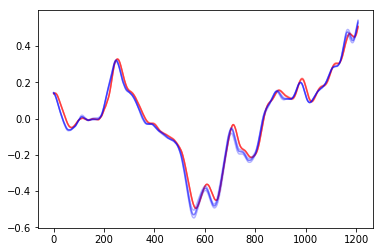

In [260]:
a=0.3
for x in xrange(pred.shape[1]):
    
    y = y_t[:,x,:4]
    p = pred[:,x,:4]
    print p.shape
    plt2.plot(p, color='r', label='Prediction', alpha=a)
    plt2.plot(y, color='b', label='Truth', alpha=a)
#     plt2.plot(np.add(y,-p), color='g', label='Truth', alpha=a)
    plt2.show()




In [261]:
x,y = inverse_scaler(X_test, y_t, preprocessor)

In [262]:
a,b = inverse_scaler(X_test, pred, preprocessor)

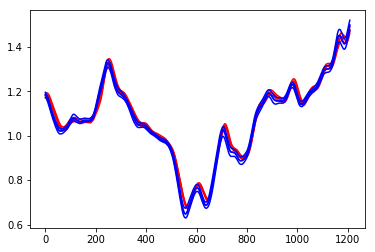

In [263]:
plt2.plot(b[:,:4], color='r', label='Prediction')
plt2.plot(y[:,:4], color='b', label='Truth')
plt2.show()

In [211]:
print y.shape
print b.shape

(1209, 6)
(1209, 6)


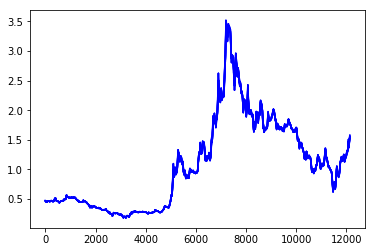

In [266]:
plt2.plot(df.as_matrix()[:,:4], color='b', label='Truth')
plt2.show()

In [ ]:
m = pd.rolling_mean(df, 24).dropna().reset_index(drop=True)

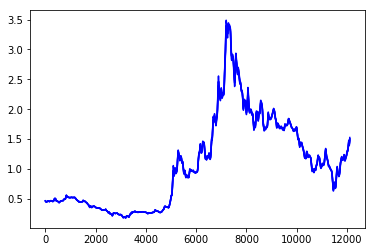

In [268]:
plt2.plot(m.as_matrix()[:,:4], color='b', label='Truth')
plt2.show()